# 鸢尾花实例

## 1、引入相关组件

In [9]:
# -*- coding: UTF-8 -*-
# 利用鸢尾花数据集，实现前向传播、反向传播，可视化loss曲线
 
# 导入所需模块
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np

## 2、导入鸢尾花数据

In [10]:
# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target

## 3、数据加工处理

In [11]:
# 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

## 4、训练

In [12]:
lr = 0.1  # 学习率为0.1
train_loss_results = []  # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500  # 循环500轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和

# 训练部分
for epoch in range(epoch):  #数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):  #batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1  # 神经网络乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])

        # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
        w1.assign_sub(lr * grads[0])  # 参数w1自更新
        b1.assign_sub(lr * grads[1])  # 参数b自更新

    # 每个epoch，打印loss信息
    print("Epoch {}, loss: {}".format(epoch, loss_all/4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

Epoch 0, loss: 0.2821310982108116
Epoch 1, loss: 0.25459614023566246
Epoch 2, loss: 0.22570250183343887
Epoch 3, loss: 0.21028400212526321
Epoch 4, loss: 0.19942265003919601
Epoch 5, loss: 0.18873638287186623
Epoch 6, loss: 0.17851299419999123
Epoch 7, loss: 0.16922875493764877
Epoch 8, loss: 0.16107673197984695
Epoch 9, loss: 0.15404684096574783
Epoch 10, loss: 0.14802725985646248
Epoch 11, loss: 0.14287303388118744
Epoch 12, loss: 0.1384414155036211
Epoch 13, loss: 0.13460607267916203
Epoch 14, loss: 0.1312607266008854
Epoch 15, loss: 0.12831821851432323
Epoch 16, loss: 0.12570794858038425
Epoch 17, loss: 0.12337299063801765
Epoch 18, loss: 0.12126746959984303
Epoch 19, loss: 0.11935433000326157
Epoch 20, loss: 0.11760355532169342
Epoch 21, loss: 0.11599067784845829
Epoch 22, loss: 0.11449568346142769
Epoch 23, loss: 0.11310208030045033
Epoch 24, loss: 0.11179621517658234
Epoch 25, loss: 0.11056671850383282
Epoch 26, loss: 0.1094040796160698
Epoch 27, loss: 0.10830028168857098
Epoch 

## 5、测试

In [13]:

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc:", acc)
    print("--------------------------")

Test_acc: 1.0
--------------------------


## 6、图形化

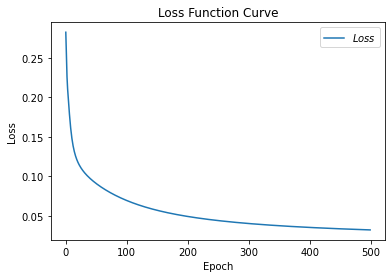

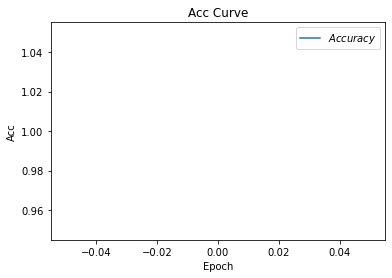

In [14]:
# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()